In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "./scripts")
import functions as f
from matplotlib import pyplot as plt
import seaborn as sns
from copy import copy
import multiprocessing as mp
import joblib
from tqdm import tqdm
from scipy import stats

In [2]:
from tqdm import tqdm
from itertools import combinations
import networkx as nx

In [188]:
def kendall_w(expt_ratings):
    if expt_ratings.ndim!=2:
        raise 'ratings matrix must be 2-dimensional'
    m = expt_ratings.shape[0] #raters
    n = expt_ratings.shape[1] # items rated
    denom = m**2*(n**3-n)
    rating_sums = np.sum(expt_ratings, axis=0)
    S = n*np.var(rating_sums)
    return 12*S/denom

In [3]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: ecoli


# Yeast Tnet

In [58]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "yeast")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [59]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [60]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 2.48 s, sys: 140 ms, total: 2.62 s
Wall time: 7.88 s


{'021C': 37631, '021D': 1059856, '021U': 26042, '030C': 8, '030T': 3370}

In [61]:
a = pd.Series(counter_orig)
a/sum(a)

021C    0.033393
021D    0.940500
021U    0.023109
030C    0.000007
030T    0.002990
dtype: float64

In [15]:
a = interaction_matrix.sum(axis=0)
tf_nodes = np.where(a != 0)[0]

In [16]:
interaction_matrix_tf = interaction_matrix[tf_nodes, :][:, tf_nodes]

In [19]:
%%time
motifs_tf, counter_tf = f.motif_search(cfg, interaction_matrix_tf, batch_size=10000)
counter_tf

CPU times: user 29.6 ms, sys: 51.7 ms, total: 81.3 ms
Wall time: 785 ms


{'021C': 1244, '021D': 1276, '021U': 1085, '030C': 8, '030T': 185}

In [41]:
a = pd.Series(counter_tf)
a/sum(a)

021C    0.327541
021D    0.335966
021U    0.285677
030C    0.002106
030T    0.048710
dtype: float64

In [31]:
G_tf = nx.DiGraph(interaction_matrix_tf)

In [32]:
nx.is_strongly_connected(G_tf), nx.is_weakly_connected(G_tf) 

(False, False)

In [55]:
w_components = list(nx.algorithms.components.weakly_connected_components(G_tf))
s_components = list(nx.algorithms.components.strongly_connected_components(G_tf))
print("Largest weakly conn. comp.:", len(w_components[0])/interaction_matrix_tf.shape[0])
print("Largest strongly conn. comp.:", len(sorted(s_components, key=len, reverse=True)[0])/interaction_matrix_tf.shape[0])

Largest weakly conn. comp.: 0.9171974522292994
Largest strongly conn. comp.: 0.3821656050955414


In [42]:
motifs = motifs_orig["030T"]

In [43]:
motifs_network = np.zeros((len(motifs), len(motifs)))
for i, j in tqdm(combinations(range(len(motifs)), 2), total=int(len(motifs)*(len(motifs)-1)/2)):
    m1, m2 = map(lambda x: set(map(int, x.split("_"))), [motifs[i], motifs[j]])
    motifs_network[i, j] = len(m1 & m2)
    motifs_network[j, i] = motifs_network[i, j]

100%|██████████| 5676765/5676765 [00:17<00:00, 319917.00it/s]


In [44]:
V = nx.Graph(motifs_network)

In [45]:
nx.is_connected(V)

True

In [46]:
ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs], [])))
len(ffl_nodes)

1201

In [47]:
interaction_matrix_ffl = interaction_matrix[ffl_nodes, :][:, ffl_nodes]

In [48]:
%%time
motifs_ffl, counter_ffl = f.motif_search(cfg, interaction_matrix_ffl, batch_size=10000)
counter_ffl

CPU times: user 693 ms, sys: 82.9 ms, total: 776 ms
Wall time: 3.23 s


{'021C': 18847, '021D': 290778, '021U': 18362, '030C': 8, '030T': 3370}

In [50]:
a = pd.Series(counter_ffl)
a/sum(a)

021C    0.056877
021D    0.877516
021U    0.055413
030C    0.000024
030T    0.010170
dtype: float64

100%|██████████| 1/1 [00:00<00:00, 202.71it/s]


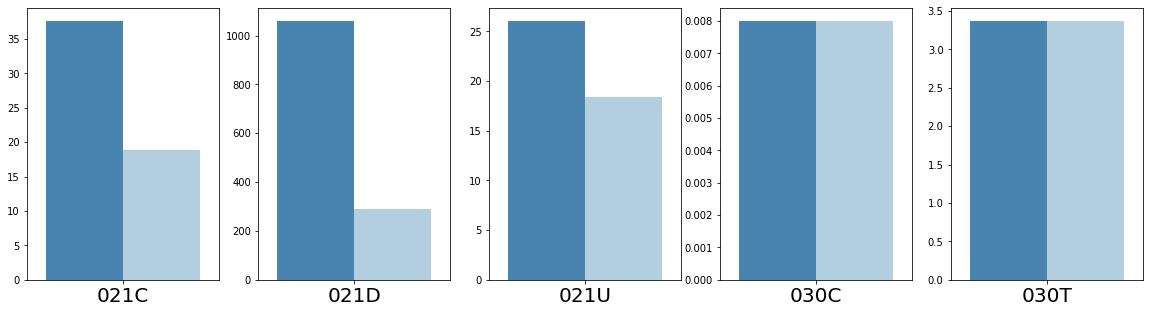

In [49]:
f.plot_distr([counter_ffl], counter_orig, label="", highlight=False);

In [21]:
ffl_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["030T"]], []))
cascade_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["021C"]], []))
uplink_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["021U"]], []))
# downlink_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["021D"]], []))

In [23]:
downlink_nodes = []
for triad in tqdm(motifs_orig["021D"]):
    for x in map(int, triad.split("_")):
        downlink_nodes.append(x)
downlink_nodes = set(downlink_nodes)

100%|██████████| 1059856/1059856 [00:01<00:00, 713607.77it/s]


In [24]:
len(ffl_nodes), len(cascade_nodes), len(uplink_nodes), len(downlink_nodes)

(1201, 4252, 2750, 4439)

In [26]:
len(ffl_nodes & cascade_nodes), len(ffl_nodes & uplink_nodes), len(ffl_nodes & downlink_nodes)

(1198, 1080, 1201)

In [28]:
tf_nodes = set(tf_nodes)
len(tf_nodes)

157

In [29]:
len(tf_nodes & ffl_nodes), len(tf_nodes & cascade_nodes), len(tf_nodes & uplink_nodes), len(tf_nodes & downlink_nodes)

(126, 146, 157, 155)

In [30]:
np.array([126, 146, 157, 155])/len(tf_nodes)

array([0.80254777, 0.92993631, 1.        , 0.98726115])

# Nodes participation

In [95]:
# node_part = pd.DataFrame(index=range(interaction_matrix.shape[0]), columns=counter_orig.keys())
node_part = {motif: np.zeros(interaction_matrix.shape[0]) for motif in counter_orig.keys()}
for motif in tqdm(counter_orig.keys()):
    for triad in motifs_orig[motif]:
        for x in map(int, triad.split("_")):
            node_part[motif][x] += 1
node_part_df = pd.DataFrame(index=range(interaction_matrix.shape[0]), columns=counter_orig.keys())
for motif, data in node_part.items():
    node_part_df[motif] = data.astype(int)

100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


In [138]:
node_part_df.sort_values("030T", ascending=False).head(50)

,021C,021D,021U,030C,030T
1308,2342,18464,727,1,362
762,1421,22881,978,0,355
923,1555,19394,1023,1,298
3207,2463,36966,1072,1,295
2536,2432,10987,516,1,293
2546,1716,23246,1012,2,265
4336,1824,13739,789,3,261
2058,1526,27238,920,0,257
3221,955,16629,714,0,216
2133,858,4306,631,0,202


In [198]:
n = interaction_matrix.shape[0]
ratings = pd.DataFrame(index=range(n), columns=node_part_df.columns)
for motif_name in node_part_df.columns:
    ratings[motif_name] = pd.Series(index=node_part_df.sort_values(motif_name, ascending=False).index, data=range(1, n+1))

In [201]:
kendall_w(ratings.values)

0.0

In [165]:
TOP_NODES = 50

In [209]:
n_top = list(range(50, 500, 10))
fraction = {"ffl_x_casc": [], "ffl_x_uplink": [], "ffl_x_downlink": []}
for n in n_top:
    motif_name = "030T"
    df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
    ffl_nodes_top = set(df.head(n).index)
    motif_name = "021U"
    df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
    uplink_nodes_top = set(df.head(n).index)
    motif_name = "021D"
    df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
    downlink_nodes_top = set(df.head(n).index)
    motif_name = "021C"
    df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
    cascade_nodes_top = set(df.head(n).index)
    fraction["ffl_x_casc"].append(len(ffl_nodes_top & cascade_nodes_top)/n)
    fraction["ffl_x_uplink"].append(len(ffl_nodes_top & uplink_nodes_top)/n)
    fraction["ffl_x_downlink"].append(len(ffl_nodes_top & downlink_nodes_top)/n)

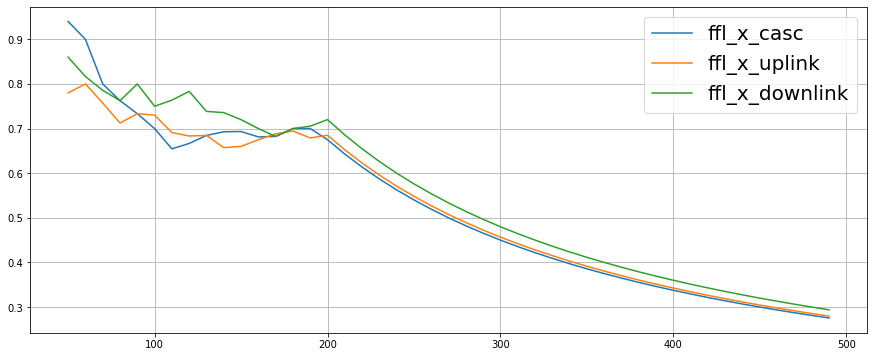

In [214]:
plt.figure(figsize=(15, 6))
plt.grid()
plt.plot(n_top, fraction["ffl_x_casc"])
plt.plot(n_top, fraction["ffl_x_uplink"])
plt.plot(n_top, fraction["ffl_x_downlink"])
plt.legend(["ffl_x_casc", "ffl_x_uplink", "ffl_x_downlink"], fontsize=20)

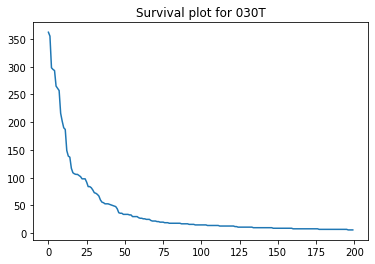

In [182]:
motif_name = "030T"
df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
plt.title(f"Survival plot for {motif_name}")
plt.plot(range(len(df)), df.values)
ffl_nodes_top = set(df.head(TOP_NODES).index)

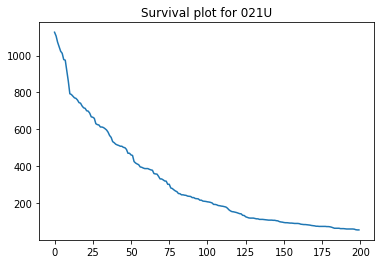

In [183]:
motif_name = "021U"
df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
plt.title(f"Survival plot for {motif_name}")
plt.plot(range(len(df)), df.values)
uplink_nodes_top = set(df.head(TOP_NODES).index)

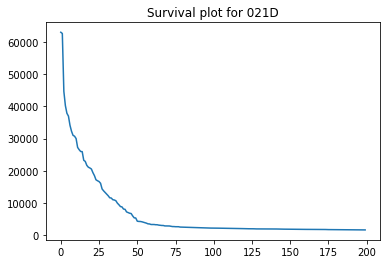

In [184]:
motif_name = "021D"
df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
plt.title(f"Survival plot for {motif_name}")
plt.plot(range(len(df)), df.values)
downlink_nodes_top = set(df.head(TOP_NODES).index)

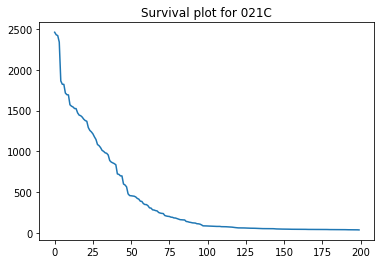

In [185]:
motif_name = "021C"
df = node_part_df.sort_values(motif_name, ascending=False)[motif_name].head(200)
plt.title(f"Survival plot for {motif_name}")
plt.plot(range(len(df)), df.values)
cascade_nodes_top = set(df.head(TOP_NODES).index)

In [186]:
len(ffl_nodes_top), len(cascade_nodes_top), len(uplink_nodes_top), len(downlink_nodes_top)

(50, 50, 50, 50)

In [187]:
len(ffl_nodes_top & cascade_nodes_top), len(ffl_nodes_top & uplink_nodes_top), len(ffl_nodes_top & downlink_nodes_top)

(47, 39, 43)

In [97]:
# pd.Series(node_part_df["030T"]).value_counts().head(50)

In [131]:
G = nx.DiGraph(interaction_matrix)
paths_gen = nx.all_pairs_shortest_path_length(G)
n = interaction_matrix.shape[0]
paths_matrix = np.array([[np.inf]*n]*n)

In [132]:
for source, paths in tqdm(paths_gen):
    for target, length in list(paths.items())[1:]:
        paths_matrix[target, source] = length

4441it [00:00, 4812.04it/s]


Total network

In [24]:
G = nx.DiGraph(interaction_matrix)

In [25]:
nx.is_strongly_connected(G), nx.is_weakly_connected(G) 

(False, True)

In [49]:
%%time
ecc = nx.eccentricity(G.to_undirected())

CPU times: user 52.7 s, sys: 71.2 ms, total: 52.8 s
Wall time: 52.8 s


In [50]:
pd.Series(ecc).value_counts(normalize=True)

5    0.843279
6    0.107408
4    0.049313
dtype: float64

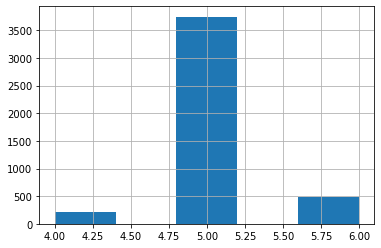

In [74]:
pd.Series(ecc).hist(bins=5);

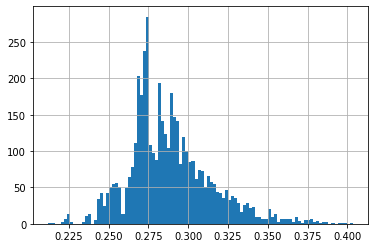

In [44]:
cl_centr = pd.Series(nx.centrality.closeness_centrality(G.to_undirected()))
cl_centr.hist(bins=100);

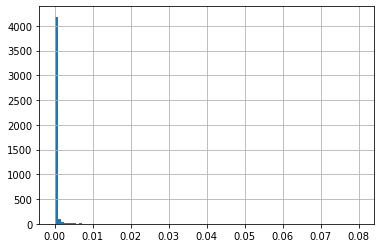

In [47]:
cl_centr = pd.Series(nx.centrality.betweenness_centrality(G.to_undirected()))
cl_centr.hist(bins=100);

FFL network

In [52]:
G_ffl = nx.DiGraph(interaction_matrix_ffl)

In [53]:
nx.is_strongly_connected(G_ffl), nx.is_weakly_connected(G_ffl) 

(False, True)

In [54]:
%%time
ecc_ffl = nx.eccentricity(G_ffl.to_undirected())

CPU times: user 4.85 s, sys: 6.53 ms, total: 4.85 s
Wall time: 4.85 s


In [55]:
pd.Series(ecc_ffl).value_counts(normalize=True)

4    0.937552
5    0.037469
3    0.024979
dtype: float64

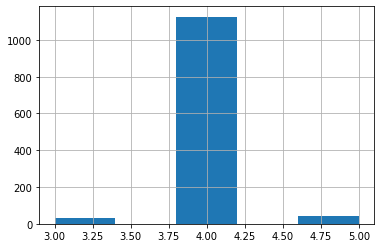

In [75]:
pd.Series(ecc_ffl).hist(bins=5);

In [76]:
center_ffl = nx.center(G_ffl.to_undirected())

In [77]:
len(center_ffl)

30

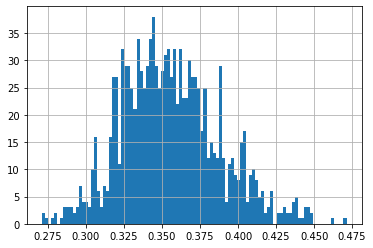

In [43]:
cl_centr_ffl = pd.Series(nx.centrality.closeness_centrality(G_ffl.to_undirected()))
cl_centr_ffl.hist(bins=100);

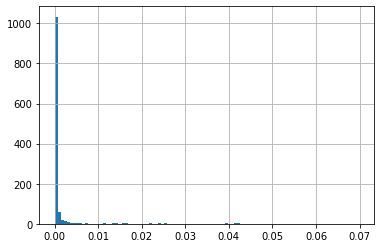

In [48]:
cl_centr_ffl = pd.Series(nx.centrality.betweenness_centrality(G_ffl.to_undirected()))
cl_centr_ffl.hist(bins=100);

In [68]:
ecc_df = pd.DataFrame(index=ecc.keys(), data=ecc.values(), columns=["total"])
ecc_df = ecc_df.join(pd.DataFrame(index=ecc_ffl.keys(), data=ecc_ffl.values(), columns=["ffl"]), how="left")
ecc_df["diff"] = ecc_df.total - ecc_df.ffl

In [72]:
ecc_df["diff"].value_counts(dropna=False)

 NaN    3240
 1.0     939
 2.0     169
 0.0      90
 3.0       2
-1.0       1
Name: diff, dtype: int64

In [102]:
paths_ffl = {}
for lengths in nx.all_pairs_shortest_path_length(G_ffl):
    paths_ffl[lengths[0]] = pd.Series(lengths[1]).max()
paths_ffl = pd.Series(paths_ffl)

In [110]:
paths_ffl.value_counts().sort_index()

0      15
1       7
2       6
4       3
5      29
6     147
7     358
8     266
9     198
10     63
11     30
12     52
13     17
14      1
15      1
16      7
17      1
dtype: int64

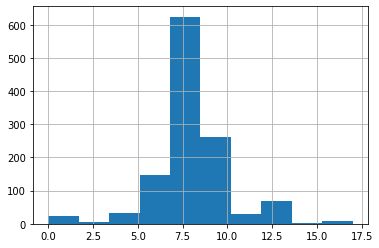

In [106]:
paths_ffl.hist();

In [111]:
paths = {}
for lengths in tqdm(nx.all_pairs_shortest_path_length(G)):
    paths[lengths[0]] = pd.Series(lengths[1]).max()
paths = pd.Series(paths)

4441it [00:02, 2090.97it/s]


In [113]:
paths.value_counts().sort_index()

0      31
1     183
2      93
3      44
4       3
5      34
6     210
7     831
8     884
9     775
10    492
11    221
12    152
13    193
14    127
15     18
16    129
17     21
dtype: int64

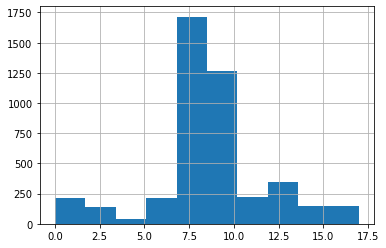

In [114]:
paths.hist();

In [122]:
paths_df = pd.DataFrame(index=paths.index, data=paths.values, columns=["total"])
paths_df = paths_df.join(pd.DataFrame(index=paths_ffl.index, data=paths_ffl.values, columns=["ffl"]), how="left")
paths_df["diff"] = paths_df.total - paths_df.ffl

In [128]:
x = paths_df["diff"].value_counts(dropna=True, normalize=True); x

 1.0     0.159867
 0.0     0.144047
 2.0     0.124063
-1.0     0.089925
 3.0     0.079101
-2.0     0.062448
 4.0     0.048293
-3.0     0.034138
 7.0     0.032473
 5.0     0.029975
 6.0     0.026644
-4.0     0.025812
 8.0     0.024979
-5.0     0.024979
-6.0     0.024147
 9.0     0.014988
-7.0     0.014988
-8.0     0.010824
-9.0     0.009159
 10.0    0.006661
-10.0    0.003331
 11.0    0.002498
-12.0    0.002498
 16.0    0.001665
 12.0    0.001665
-11.0    0.000833
Name: diff, dtype: float64

In [140]:
x.sort_index()[0:].sum()

0.6969192339716902

# Ecoli Tnet

In [4]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "ecoli")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: ecoli


In [5]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [6]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 665 ms, sys: 74.5 ms, total: 740 ms
Wall time: 2.53 s


{'021C': 3938, '021D': 329287, '021U': 4365, '030C': 0, '030T': 1392}

In [7]:
motifs = motifs_orig["030T"]

In [8]:
motifs_network = np.zeros((len(motifs), len(motifs)))
for i, j in tqdm(combinations(range(len(motifs)), 2), total=int(len(motifs)*(len(motifs)-1)/2)):
    m1, m2 = map(lambda x: set(map(int, x.split("_"))), [motifs[i], motifs[j]])
    motifs_network[i, j] = len(m1 & m2)
    motifs_network[j, i] = motifs_network[i, j]

100%|██████████| 968136/968136 [00:03<00:00, 311856.69it/s]


In [9]:
V = nx.Graph(motifs_network)

In [10]:
nx.is_connected(V)

False

In [11]:
components = list(nx.algorithms.components.connected_components(V))
main_ffl_motifs = [motifs[i] for i in components[0]]

In [12]:
len(main_ffl_motifs), len(main_ffl_motifs)/len(motifs)

(1380, 0.9913793103448276)

In [13]:
ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in main_ffl_motifs], [])))
len(ffl_nodes)

693

In [14]:
interaction_matrix_ffl = interaction_matrix[ffl_nodes, :][:, ffl_nodes]

In [15]:
%%time
motifs_ffl, counter_ffl = f.motif_search(cfg, interaction_matrix_ffl, batch_size=10000)
counter_ffl

CPU times: user 297 ms, sys: 58.7 ms, total: 356 ms
Wall time: 1.87 s


{'021C': 2167, '021D': 130868, '021U': 2627, '030C': 0, '030T': 1380}

100%|██████████| 1/1 [00:00<00:00, 231.70it/s]


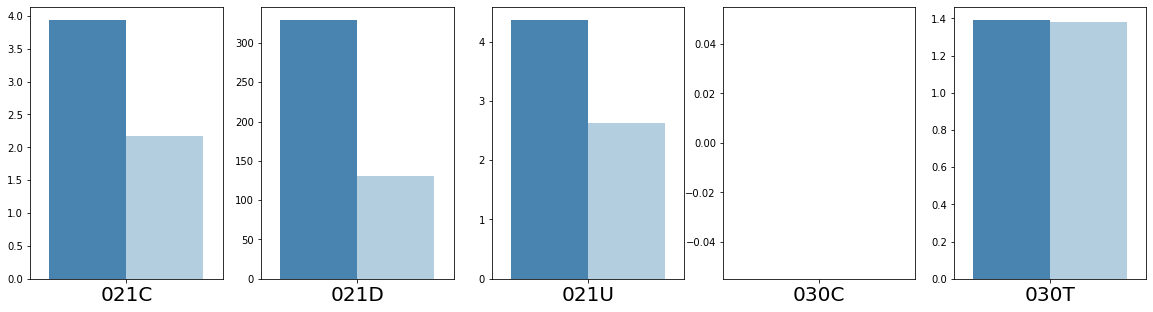

In [16]:
f.plot_distr([counter_ffl], counter_orig, label="", highlight=False);

In [17]:
ffl_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["030T"]], []))
cascade_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["021C"]], []))
uplink_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["021U"]], []))
# downlink_nodes = set(sum([list(map(int, x.split("_"))) for x in motifs_orig["021D"]], []))

In [22]:
downlink_nodes = []
for triad in tqdm(motifs_orig["021D"]):
    for x in map(int, triad.split("_")):
        downlink_nodes.append(x)
downlink_nodes = set(downlink_nodes)

100%|██████████| 329287/329287 [00:00<00:00, 645802.69it/s]


In [23]:
len(ffl_nodes), len(cascade_nodes), len(uplink_nodes), len(downlink_nodes)

(717, 1361, 968, 1896)

In [24]:
len(ffl_nodes & cascade_nodes), len(ffl_nodes & uplink_nodes), len(ffl_nodes & downlink_nodes)

(673, 540, 711)

In [25]:
673/717, 540/717, 711/717

(0.9386331938633193, 0.7531380753138075, 0.9916317991631799)

Total network

In [21]:
G = nx.DiGraph(interaction_matrix)

In [22]:
nx.is_strongly_connected(G), nx.is_weakly_connected(G) 

(False, False)

In [28]:
w_components = list(nx.algorithms.components.weakly_connected_components(G))
s_components = list(nx.algorithms.components.strongly_connected_components(G))
print("Largest weakly conn. comp.:", len(w_components[0])/interaction_matrix.shape[0])
print("Largest strongly conn. comp.:", len(s_components[0])/interaction_matrix.shape[0])

Largest weakly conn. comp.: 0.94679186228482
Largest strongly conn. comp.: 0.0005216484089723526


In [33]:
main_comp_nodes = w_components[0]
interaction_matrix_conn = interaction_matrix[list(main_comp_nodes), :][:, list(main_comp_nodes)]
interaction_matrix_conn.shape
G = nx.DiGraph(interaction_matrix_conn)

In [34]:
%%time
ecc = nx.eccentricity(G.to_undirected())

CPU times: user 8.02 s, sys: 16.2 ms, total: 8.03 s
Wall time: 8.04 s


In [ ]:
pd.Series(ecc).value_counts(normalize=True)

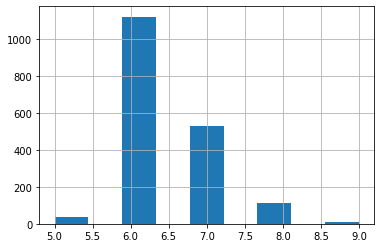

In [37]:
pd.Series(ecc).hist(bins=9);

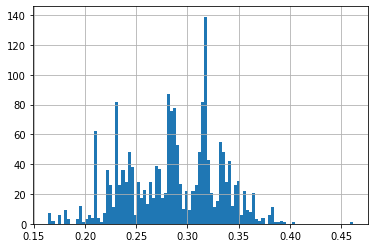

In [38]:
cl_centr = pd.Series(nx.centrality.closeness_centrality(G.to_undirected()))
cl_centr.hist(bins=100);

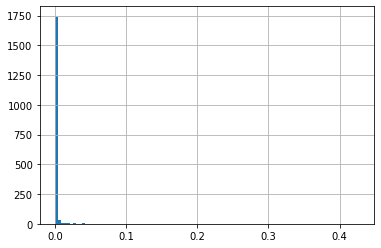

In [39]:
cl_centr = pd.Series(nx.centrality.betweenness_centrality(G.to_undirected()))
cl_centr.hist(bins=100);

FFL network

In [40]:
G_ffl = nx.DiGraph(interaction_matrix_ffl)

In [41]:
nx.is_strongly_connected(G_ffl), nx.is_weakly_connected(G_ffl) 

(False, True)

In [42]:
%%time
ecc_ffl = nx.eccentricity(G_ffl.to_undirected())

CPU times: user 1.32 s, sys: 2.96 ms, total: 1.32 s
Wall time: 1.32 s


In [43]:
pd.Series(ecc_ffl).value_counts(normalize=True)

5    0.544012
4    0.440115
6    0.015873
dtype: float64

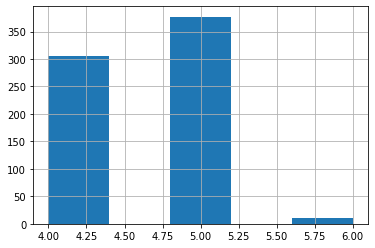

In [44]:
pd.Series(ecc_ffl).hist(bins=5);

In [45]:
center_ffl = nx.center(G_ffl.to_undirected())

In [46]:
len(center_ffl)

305

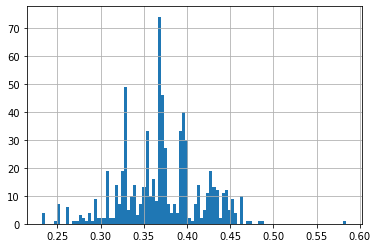

In [47]:
cl_centr_ffl = pd.Series(nx.centrality.closeness_centrality(G_ffl.to_undirected()))
cl_centr_ffl.hist(bins=100);

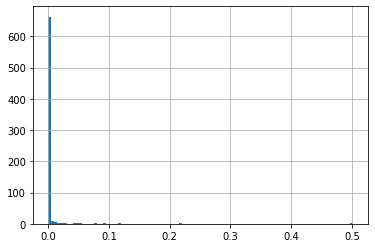

In [48]:
cl_centr_ffl = pd.Series(nx.centrality.betweenness_centrality(G_ffl.to_undirected()))
cl_centr_ffl.hist(bins=100);

In [49]:
ecc_df = pd.DataFrame(index=ecc.keys(), data=ecc.values(), columns=["total"])
ecc_df = ecc_df.join(pd.DataFrame(index=ecc_ffl.keys(), data=ecc_ffl.values(), columns=["ffl"]), how="left")
ecc_df["diff"] = ecc_df.total - ecc_df.ffl

In [50]:
ecc_df["diff"].value_counts(dropna=False)

NaN    1122
2.0     282
1.0     261
3.0     109
4.0      20
0.0      19
5.0       2
Name: diff, dtype: int64

In [51]:
paths_ffl = {}
for lengths in nx.all_pairs_shortest_path_length(G_ffl):
    paths_ffl[lengths[0]] = pd.Series(lengths[1]).max()
paths_ffl = pd.Series(paths_ffl)

In [52]:
paths_ffl.value_counts().sort_index()

0     23
1     31
2     18
3    202
4    174
5    146
6     25
7     54
8     11
9      9
dtype: int64

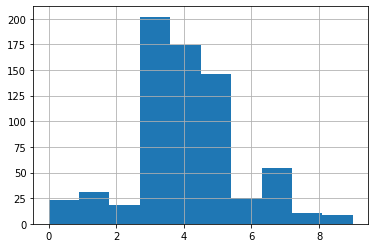

In [53]:
paths_ffl.hist();

In [54]:
paths = {}
for lengths in tqdm(nx.all_pairs_shortest_path_length(G)):
    paths[lengths[0]] = pd.Series(lengths[1]).max()
paths = pd.Series(paths)

1815it [00:00, 3532.50it/s]


In [55]:
paths.value_counts().sort_index()

0      75
1     410
2      92
3     390
4     337
5     323
6      61
7      93
8      12
9      15
10      7
dtype: int64

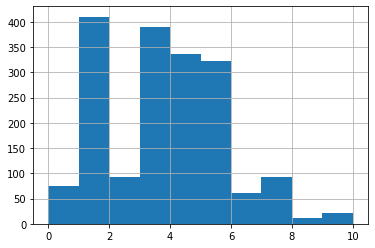

In [56]:
paths.hist();

In [57]:
paths_df = pd.DataFrame(index=paths.index, data=paths.values, columns=["total"])
paths_df = paths_df.join(pd.DataFrame(index=paths_ffl.index, data=paths_ffl.values, columns=["ffl"]), how="left")
paths_df["diff"] = paths_df.total - paths_df.ffl

In [58]:
x = paths_df["diff"].value_counts(dropna=True, normalize=True); x

 1.0    0.145743
-2.0    0.141414
 0.0    0.139971
-1.0    0.134199
-3.0    0.111111
 2.0    0.093795
-4.0    0.090909
 3.0    0.041847
 4.0    0.040404
-5.0    0.021645
-6.0    0.020202
-7.0    0.008658
 5.0    0.004329
 6.0    0.002886
 7.0    0.002886
Name: diff, dtype: float64

In [59]:
x.sort_index()[0:].sum()

0.47186147186147187